In [72]:
from dataclasses import dataclass
from typing import Tuple, Dict, Any, Optional, List
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import time
import numpy as np
import wandb
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from torchvision.transforms import functional as F
from dataclasses import replace
import os, wandb
import random
import math
import pandas as pd
from PIL import Image
import shutil
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    precision_recall_fscore_support,
    accuracy_score,
    confusion_matrix)

## Data preparation

Before doing the experimentations, we need to prepare our data or training.

The first thing to do is to fix our csv. We found that the latest csv had not the class id column, which is a mistake. We are going to add the column by using a dictionary to map labels to class id.

data = pd.read_csv('sports.csv')
labels = data.labels.unique()
class_ids = data["class id"].unique()
dict_label_id = dict(zip(labels, class_ids))

In [ ]:
# df = pd.read_csv('sports4.csv')
# df['class id'] = df['labels'].map(dict_label_id)
# df.to_csv('sports5.csv', index=False)

Now we are going to prepare our data for training. In order to do the training easier, we are going to remap class id. This means we are going to assing the 50 classes new ids from 1 to 50, keeping a stucture that that maps this new ids to the others.

Besides this, we also are going to separate the data using the csv.

In [23]:
clean_data = pd.read_csv("/kaggle/working/sports5_augmented10000.csv")

unique_ids = sorted(clean_data["class id"].unique())
id2new = {old: i for i, old in enumerate(unique_ids)}   # original -> new
new2id = {new: old for old, new in id2new.items()}      # new -> original

clean_data["class id"] = clean_data["class id"].map(id2new)

num_classes = len(unique_ids)
print("Nun classes:", num_classes)

# (opcional) mantener tus prints de tamaños
CountTrain = clean_data[clean_data['data set'] == 'train']['labels'].count()
CountVal = clean_data[clean_data['data set'] == 'valid']['labels'].count()
CountTest = clean_data[clean_data['data set'] == 'test']['labels'].count()
Total = CountTrain + CountVal + CountTest
print(f'Train Size: {CountTrain} -> {CountTrain*100/Total}')
print(f'Val Size: {CountVal} -> {CountVal*100/Total}')
print(f'Test Size: {CountTest} -> {CountTest*100/Total}')

train_data = clean_data[clean_data["data set"] == "train"]
valid_data = clean_data[clean_data["data set"] == "valid"]
test_data  = clean_data[clean_data["data set"] == "test"]

Nun classes: 50
Train Size: 10022 -> 95.2480517011975
Val Size: 250 -> 2.3759741494012547
Test Size: 250 -> 2.3759741494012547


In [1]:
# info_clases = (
#     train_data.groupby("class id")["labels"].first()
#     .reset_index()
#     .rename(columns={"class id": "new_id"})
# )

# info_clases["original_id"] = info_clases["new_id"].map(new2id)
# print(info_clases.sort_values("new_id"))

Here we can see the new ids assigned to each class and its previous id.

Now it is time to create the dataloaders. To do this, we have created a class which prepares the images using the filepaths of the csv, checking the size expected and noralizing the image as well.

In [25]:
class SportsDataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = Image.open("/kaggle/working/data/" + row['filepaths']).convert("RGB")
        label = int(row['class id'])
    
        # Resize a 224x224 para que coincida con CNNConfig
        image = F.resize(image, [224, 224])
    
        # Image normalization
        image = F.to_tensor(image)
        image = F.normalize(image, mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    
        return image, label

Here we create the dat loaders to feed our networks.

In [26]:
train_dataset = SportsDataset(train_data)
valid_dataset = SportsDataset(valid_data)
test_dataset  = SportsDataset(test_data)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=4,pin_memory=True)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size,shuffle=False,num_workers=4,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=4,pin_memory=True)

The following cell contains the config to our model, whith all its possibilities.
In it we define, input and output sizes, all convolution layers which will have de CNN, the size of the mlp part with its correspondants variats (dropout, for example). The other parameters are related with the training, such has batch_size or optimization parameters (optimizers, weight_decay, learniing_rate, ...) Here we also define that we wan to use CUDA GPU instead of GPU.

The predetemined parameters in this config are related with our baseline model, which we will further comment in the expeerimentation part.

In [27]:
@dataclass(frozen=True)
class CNNConfig:
    
    input_channels: int = 3
    input_height: int = 224
    input_width: int = 224
    output_dim: int = 50

    conv_layers: Tuple[Dict[str, Any], ...] = (
        {
            "out_channels": 32,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.0,
            "pool": {"type": "max", "kernel": 2, "stride": 2},
        },
        {
            "out_channels": 64,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.0,
            "pool": {"type": "max", "kernel": 2, "stride": 2},
        },
    )


    hidden_layers: Tuple[int, ...] = (256,)
    fc_dropout: float = 0.0
    final_activation: Optional[str] = None 

    skip_connections: bool = False

    optimizer: str = "adam"
    learning_rate: float = 1e-3
    momentum: float = 0.9
    betas: Tuple[float, float] = (0.9, 0.999)

    weight_decay: float = 0.0

    batch_size: int = 32
    epochs: int = 50
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    run_name: str = "Experiment1"

Next, we have the CNN module, which uses the config to correctlz build the CNN. We can see the different methods used like build_conv_blocks, which creates the CNN specific part of the model. Next function buiilds the mlp part. After this we have the forward part and also the some functions reated with the activations and inicialiyation.

In [28]:
class CNN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self._build_conv_blocks()
        self._build_classifier()
        self._initialize_weights()  # always 'normal'

    def _build_conv_blocks(self):
        layers = nn.ModuleList()
        in_channels = self.config.input_channels

        for block_cfg in self.config.conv_layers:
            out_ch = int(block_cfg["out_channels"])
            k = int(block_cfg.get("kernel_size", 3))
            s = int(block_cfg.get("stride", 1))
            p = int(block_cfg.get("padding", k // 2))
            activation = block_cfg.get("activation", "relu")
            use_bn = bool(block_cfg.get("batch_norm", False))
            drop = float(block_cfg.get("dropout", 0.0))
            pool_cfg = block_cfg.get("pool", None)

            seq = []
            # Conv layer
            seq.append(nn.Conv2d(in_channels, out_ch, kernel_size=k, stride=s, padding=p, bias=not use_bn))
            if use_bn:
                seq.append(nn.BatchNorm2d(out_ch))
            seq.append(self._get_activation_module(activation))
            if drop > 0:
                seq.append(nn.Dropout2d(drop))
            # Pooling
            if pool_cfg:
                ptype = pool_cfg.get("type", "max")
                pk = int(pool_cfg.get("kernel", 2))
                ps = int(pool_cfg.get("stride", pk))
                if ptype == "max":
                    seq.append(nn.MaxPool2d(kernel_size=pk, stride=ps))
                else:
                    seq.append(nn.AvgPool2d(kernel_size=pk, stride=ps))

            # Determine if residual connection is possible
            residual_ok = self.config.skip_connections and (in_channels == out_ch) and (s == 1)
            layers.append(nn.ModuleDict({"block": nn.Sequential(*seq),
                                        "residual": nn.Identity() if residual_ok else None}))
            in_channels = out_ch

        self.conv_blocks = layers
        self.final_conv_channels = in_channels
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        

    def _build_classifier(self):
        fc_layers = []
        in_features = self.final_conv_channels

        prev = in_features
        for h in self.config.hidden_layers:
            fc_layers.append(nn.Linear(prev, h))
            fc_layers.append(nn.ReLU())
            if self.config.fc_dropout and self.config.fc_dropout > 0:
                fc_layers.append(nn.Dropout(self.config.fc_dropout))
            prev = h

        # final output layer
        fc_layers.append(nn.Linear(prev, self.config.output_dim))
        self.classifier = nn.Sequential(*fc_layers)

    def forward(self, x):
        out = x
        for entry in self.conv_blocks:
            block = entry["block"]
            residual_flag = entry["residual"] is not None
            if residual_flag:
                prev = out
                out = block(out)
                if prev.shape == out.shape:
                    out = out + prev
            else:
                out = block(out)

        out = self.global_avg_pool(out)
        out = torch.flatten(out, 1) 
        logits = self.classifier(out)
        return logits

    def _get_activation_module(self, name: str) -> nn.Module:
        n = (name or "relu").lower()
        if n == "relu":
            return nn.ReLU(inplace=True)
        if n == "leakyrelu":
            return nn.LeakyReLU(0.01, inplace=True)
        if n == "tanh":
            return nn.Tanh()
        if n == "sigmoid":
            return nn.Sigmoid()
        raise ValueError(f"Unsupported activation: {name}")

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)


Next we have the most important cell of this part, the training. We will not exlpain a lot this part as the cell is verz similar to the one in the last project. The function benefits from the Config and CNN module to perform training and validation calculating all metrics for the validation part epoch by epoch.

In [29]:
def train_model(
    model: nn.Module,
    config,
    train_loader: DataLoader,
    val_loader: Optional[DataLoader] = None,
    device: Optional[str] = None,
):
    if device is None:
        device = config.device

    device = torch.device(device)

    print(device)
    model.to(device)
    # Initialize wandb
    wandb.init(
        project="SportsClassification",
        name=config.run_name,
        config={k: v for k, v in config.__dict__.items()},
        reinit=True,
    )
    # wandb.watch(model, log="all", log_freq=100)
    # Loss
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    # Optimizer
    if config.optimizer.lower() == "adam":
        optimizer = optim.Adam(
            model.parameters(), lr=config.learning_rate, betas=getattr(config, "betas", (0.9, 0.999)), weight_decay=config.weight_decay
        )
    elif config.optimizer.lower() == "sgd":
        optimizer = optim.SGD(
            model.parameters(), lr=config.learning_rate, momentum=getattr(config, "momentum", 0.0), weight_decay=config.weight_decay
        )
    else:
        raise ValueError(f"Unsupported optimizer: {config.optimizer}")

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode="min",
        factor=0.5,
        patience=3
    )

    best_model_state = model.state_dict().copy()
    best_val_f1 = -1.0

    # Helper to compute multi-class metrics (macro precision/recall/f1 & accuracy)
    def compute_multiclass_metrics(all_preds, all_labels, num_classes):
        # all_preds / all_labels: 1D numpy arrays
        cm_tp = np.zeros(num_classes, dtype=np.int64)
        cm_fp = np.zeros(num_classes, dtype=np.int64)
        cm_fn = np.zeros(num_classes, dtype=np.int64)

        for cls in range(num_classes):
            cls_pred = (all_preds == cls)
            cls_true = (all_labels == cls)
            tp = int(np.logical_and(cls_pred, cls_true).sum())
            fp = int(np.logical_and(cls_pred, ~cls_true).sum())
            fn = int(np.logical_and(~cls_pred, cls_true).sum())
            cm_tp[cls] = tp
            cm_fp[cls] = fp
            cm_fn[cls] = fn

        precisions = np.zeros(num_classes, dtype=float)
        recalls = np.zeros(num_classes, dtype=float)
        f1s = np.zeros(num_classes, dtype=float)

        for cls in range(num_classes):
            tp = cm_tp[cls]
            fp = cm_fp[cls]
            fn = cm_fn[cls]
            prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
            precisions[cls] = prec
            recalls[cls] = rec
            f1s[cls] = f1

        macro_prec = float(np.mean(precisions))
        macro_rec = float(np.mean(recalls))
        macro_f1 = float(np.mean(f1s))
        accuracy = float((all_preds == all_labels).sum() / len(all_labels)) if len(all_labels) > 0 else 0.0

        return {
            "accuracy": accuracy,
            "macro_precision": macro_prec,
            "macro_recall": macro_rec,
            "macro_f1": macro_f1,
            "per_class_precision": precisions,
            "per_class_recall": recalls,
            "per_class_f1": f1s,
        }

    num_epochs = int(config.epochs)
    num_classes = int(config.output_dim)

    early_stop_patience = 10
    early_stop_counter = 0
    best_val_acc = -1.0
    best_model_state = None
    best_epoch = None

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        train_loss_sum = 0.0
        train_samples = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device).long()  # CrossEntropy expects Long targets of shape (B,)

            optimizer.zero_grad()
            outputs = model(xb)  # logits (B, C)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            batch_size = xb.size(0)
            train_loss_sum += loss.item() * batch_size
            train_samples += batch_size

        avg_train_loss = train_loss_sum / train_samples if train_samples > 0 else 0.0

        if val_loader is not None:
            model.eval()
            val_loss_sum = 0.0
            val_samples = 0
            all_preds_list = []
            all_labels_list = []
        
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(device)
                    yb = yb.to(device).long()
                    outputs = model(xb)  # (B, C)
                    loss = criterion(outputs, yb)
        
                    batch_size = xb.size(0)
                    val_loss_sum += loss.item() * batch_size
                    val_samples += batch_size
        
                    preds = outputs.argmax(dim=1).detach().cpu().numpy()
                    labels = yb.detach().cpu().numpy()
        
                    all_preds_list.append(preds)
                    all_labels_list.append(labels)
        
            avg_val_loss = val_loss_sum / val_samples if val_samples > 0 else 0.0
            all_preds = np.concatenate(all_preds_list, axis=0) if all_preds_list else np.array([], dtype=int)
            all_labels = np.concatenate(all_labels_list, axis=0) if all_labels_list else np.array([], dtype=int)
        
            metrics = compute_multiclass_metrics(all_preds, all_labels, num_classes)
        
            # Save best model by validation accuracy and reset early-stop counter if improved
            if metrics["accuracy"] > best_val_acc:
                best_val_acc = metrics["accuracy"]
                # move tensors to CPU to avoid holding CUDA memory
                best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
                best_epoch = epoch + 1
                early_stop_counter = 0
            else:
                early_stop_counter += 1
        
            # Log epoch metrics to wandb
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "val_loss": avg_val_loss,
                "val_accuracy": metrics["accuracy"],
                "val_macro_precision": metrics["macro_precision"],
                "val_macro_recall": metrics["macro_recall"],
                "val_macro_f1": metrics["macro_f1"],
                "learning_rate": optimizer.param_groups[0]["lr"],
                "epoch_time_sec": time.time() - epoch_start,
            })
        
            print(
                f"Epoch [{epoch+1}/{num_epochs}] "
                f"Train Loss: {avg_train_loss:.4f} Val Loss: {avg_val_loss:.4f} "
                f"Acc: {metrics['accuracy']:.4f} Macro-F1: {metrics['macro_f1']:.4f} "
                f"(best_acc={best_val_acc:.4f} @epoch {best_epoch})"
            )
        
            # Note: keep stepping the scheduler with avg_val_loss if using ReduceLROnPlateau.
            scheduler.step(avg_val_loss)
        
            # Early stopping check (based on accuracy)
            if early_stop_counter >= early_stop_patience:
                print(f"No improvement in val_accuracy for {early_stop_counter} epochs. Early stopping.")
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                break
        
        else:
            # No validation provided: log only train loss
            wandb.log({
                "epoch": epoch + 1,
                "train_loss": avg_train_loss,
                "learning_rate": optimizer.param_groups[0]["lr"],
                "epoch_time_sec": time.time() - epoch_start,})
            print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}")

    # After training: restore best model state if validation was used
    if val_loader is not None and best_model_state is not None:
        model.load_state_dict(best_model_state)

        # final confusion matrix & logging
        # compute final predictions on validation set for confusion matrix
        model.eval()
        final_preds = []
        final_labels = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device).long()
                outputs = model(xb)
                preds = outputs.argmax(dim=1).cpu().numpy()
                labels = yb.cpu().numpy()
                final_preds.append(preds)
                final_labels.append(labels)

        final_preds = np.concatenate(final_preds, axis=0) if final_preds else np.array([], dtype=int)
        final_labels = np.concatenate(final_labels, axis=0) if final_labels else np.array([], dtype=int)

        class_names = [str(i) for i in range(num_classes)]
        try:
            wandb.log({
                "confusion_matrix_final": wandb.plot.confusion_matrix(
                    y_true=final_labels,
                    preds=final_preds,
                    class_names=class_names
                )
            })
        except Exception:
            # If wandb confusion matrix fails for many classes, still proceed
            pass

    if best_model_state is not None:
        torch.save(best_model_state, "best_model_by_val_acc.pth")
        print(f"Best model saved (epoch {best_epoch}, val_acc={best_val_acc:.4f})")
    
    # Save model artifact
    model_filename = f"{config.run_name}.pth"
    torch.save(best_model_state, model_filename)
    artifact = wandb.Artifact(config.run_name, type="model")
    artifact.add_file(model_filename)
    wandb.log_artifact(artifact)
    wandb.finish()

    return model

This code is integrated along with weight and biases in order to be able to see the results of each experiment in the web. This allows to easly see what is missing and to improve the models. In fact, the next session ensures we log in wanb in order not to do it in the code. 

### WANDB

In [30]:
os.environ["WANDB_API_KEY"] = "aceadb437e94944c3e228b5ba02d7d9b9f72e621"
wandb.login(key=os.environ["WANDB_API_KEY"], relogin=True)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Now it is time to do the experimentation. In this part, we'll use our CNNConfig in order to train the models. The first experiment will be the baseline and we will change its structure for the next experiments by changing only the parameters we feel necessary.

## Validation Metrics
- For this project, we are going to use accuracy, as we have shown along the project, the dataset is pretty balanced, so we think accuracy is a good metric to evaluate our model. Another reason to do that, is that we do not want to penalize false positives nor negatives because all sports classes are equally valauble, this is not a medical dataset where predictions are risky.

## Experiment 1

This is the basline. This experiment will have the predetermined parameters we have stated in the configuration of our network. Our baseline network has:
- 2 convolutional blocks composed by:
  
       - Convolutional Layer (first layer has 32 filters and second 64, each one with kernel_size 3x3, padding 1 and stride 1)
       - Pooling max layer with 2x2 kernel and stride 2
       - No dropout
- MLP composed by a single layer with 256 neurons without dropout
- Adam optimizer
- 0.001 learning rate
- Tipical values for momentum and betas for adam
- Batch size 32, 50 epochs

In [5]:
# baseline = CNNConfig(output_dim=num_classes)
# model = CNN(baseline)
# Experiment1_model = train_model(model, baseline, train_loader, valid_loader, device='cuda')

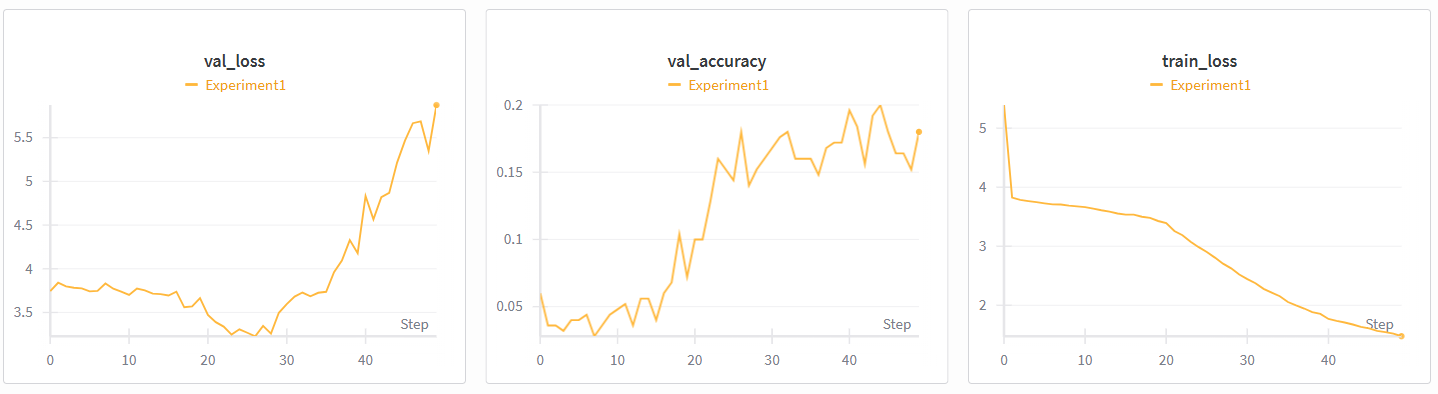

This are the results of our baseline experiment. As we commented we will be reviewing training and validation loss to see how the model behaves and we will asses the model using accuracy on the validation.

Looking solely on the accuracy, we can see that the model does not perform really well, as it only reaches 0.2, which means that it only predict well the 20% of the images. We can improve this a lot. On the other side, by looking at train and val loss we see somehitng strange. Our model kind of overfits from epoh 20 to 50.
This is really strange because the model does not give goog results. The reason beyond that may be that our CNN does not learn good the informarion of our images as it is a pretty simple network but overfits because our mlp layer of 256 does not have droput. This may explain the behaviour.

## Experiment 2

Knowing Experiment 1 results, we will change things sbout our network in order to improve the results.
On the one hand, we will make our CNN bigger by adding an extra convolustional block which has 128 output channels in order to gather more complex characteristics of the images to classificate them well.
On the other hand, we will add another bigger layer in the mlp to proccess all this information but now applying correct regularization so we do not overfit. The regularization can be seen because we add 0.3 dropout in the fully connected part and also weight_decay.

In [3]:
# exp2_config = replace(
#     baseline,
#     conv_layers=(
#         {
#             "out_channels": 32,
#             "kernel_size": 3,
#             "stride": 1,
#             "padding": 1,
#             "activation": "relu",
#             "batch_norm": True,
#             "dropout": 0.0,
#             "pool": {"type": "max", "kernel": 2, "stride": 2},
#         },
#         {
#             "out_channels": 64,
#             "kernel_size": 3,
#             "stride": 1,
#             "padding": 1,
#             "activation": "relu",
#             "batch_norm": True,
#             "dropout": 0.0,
#             "pool": {"type": "max", "kernel": 2, "stride": 2},
#         },
#         {
#             "out_channels": 128,
#             "kernel_size": 3,
#             "stride": 1,
#             "padding": 1,
#             "activation": "relu",
#             "batch_norm": True,
#             "dropout": 0.0,
#             "pool": {"type": "max", "kernel": 2, "stride": 2},
#         },
#     ),
#     hidden_layers=(512, 256), 
#     fc_dropout=0.3,           
#     weight_decay=1e-4,          
#     epochs=50,                 
#     run_name="Experiment2",     
# )

# model_exp2 = CNN(exp2_config)

# Experiment2_model = train_model(model_exp2,exp2_config,train_loader,valid_loader,device="cuda",)

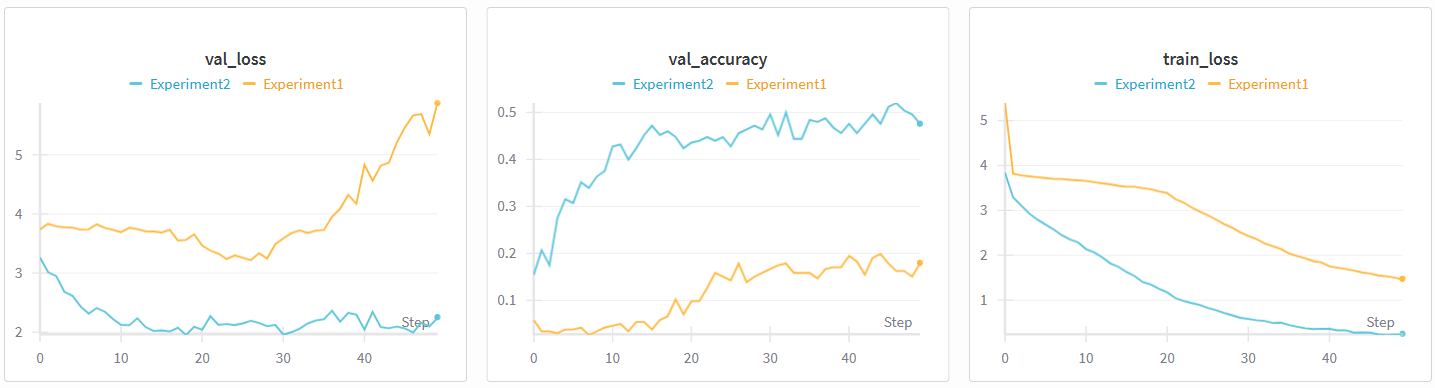

We can see how the second experiment has improved alot the results. By looking at loss, we can see how it is true that training loss decreses more than validation loss, but val loss flattens without incresing again. This means we have solved the overfitting of the last experiment, but we can do better. 
Looking at accuracy, it is clear that the CNN extracts better images information, giving a maximum accuracy of about 0.5, which is an improvment of over x2 in respect with the last experiment.

At this point, we had a time problem to execute the experiments. First experiments last 20 mins and Experiment2 1h30. To make them we used internal GPU from the computer, but from now on, we will use T4 GPU x2 in Kaggle, which we hope it speed ups the process.

## Experiment 3

For this experiment, we want to check if our actual model is overfitting or not. The reason to do this is because the training loss increased way more than the validation loss, but validation loss did not increase again. We only want to see if regularizing a little bit more we can increse performance. The changes for this experiment will be:

- Use same CNN as it has improves a lot
- batch_size 64
- Use label smoothing 0.1 in the crossentropy loss
- Use scheduler

In [4]:
# baseline = CNNConfig(output_dim=num_classes)
# exp2_config = replace(
#     baseline,
#     conv_layers=(
#         {
#             "out_channels": 32,
#             "kernel_size": 3,
#             "stride": 1,
#             "padding": 1,
#             "activation": "relu",
#             "batch_norm": True,
#             "dropout": 0.0,
#             "pool": {"type": "max", "kernel": 2, "stride": 2},
#         },
#         {
#             "out_channels": 64,
#             "kernel_size": 3,
#             "stride": 1,
#             "padding": 1,
#             "activation": "relu",
#             "batch_norm": True,
#             "dropout": 0.0,
#             "pool": {"type": "max", "kernel": 2, "stride": 2},
#         },
#         {
#             "out_channels": 128,
#             "kernel_size": 3,
#             "stride": 1,
#             "padding": 1,
#             "activation": "relu",
#             "batch_norm": True,
#             "dropout": 0.0,
#             "pool": {"type": "max", "kernel": 2, "stride": 2},
#         },
#     ),
#     hidden_layers=(512, 256), 
#     fc_dropout=0.3,           
#     weight_decay=1e-4,          
#     epochs=50,                 
#     run_name="Experiment2",     
# )

In [33]:
exp3_config = replace(exp2_config, epochs=25, run_name="Experiment3")

In [ ]:
model_exp3 = CNN(exp3_config)
Experiment3_model = train_model(model_exp3,exp3_config,train_loader,valid_loader,device="cuda")

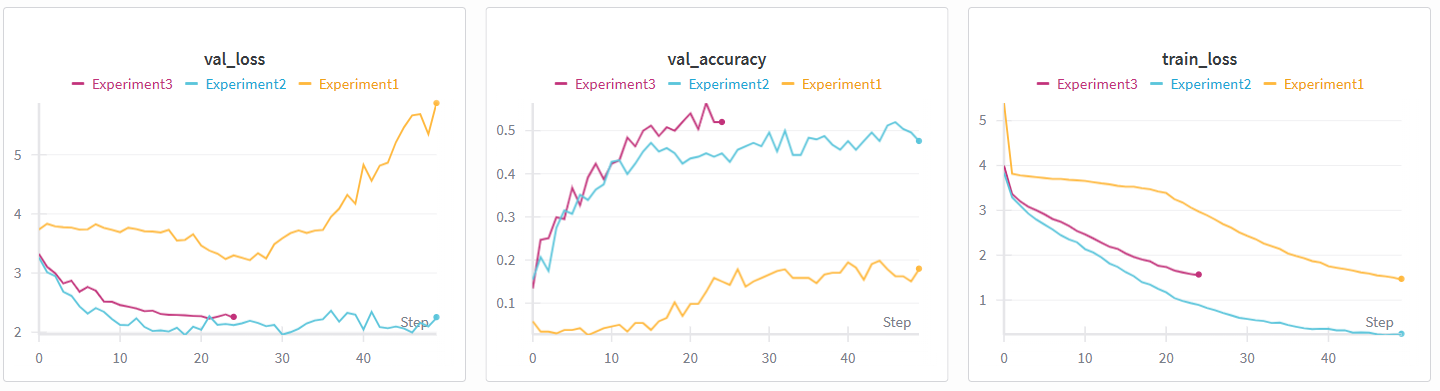

If we look at purple line, we can see an improvement in the validation accuracy, clearly reaching over 50% in less epochs. This is a sign that we still had a little bit of overfitting, which has been imrpoved with these last changes. In the loss, we can see how now training and validation loss are closer to each one, meaning we are doing things well.

## Experiment 4

However, we think that 25 epochs ahve not been enough to give the best results. As now training is faster (it only lasted 15 mins), we will go back to 50 epochs with these new regularization techniques in order to see if we get better results.

In [34]:
exp4_config = replace(exp3_config, epochs=50, run_name="Experiment4")

In [ ]:
# model_exp4 = CNN(exp4_config)
# Experiment4_model = train_model(model_exp4,exp4_config,train_loader,valid_loader,device="cuda")

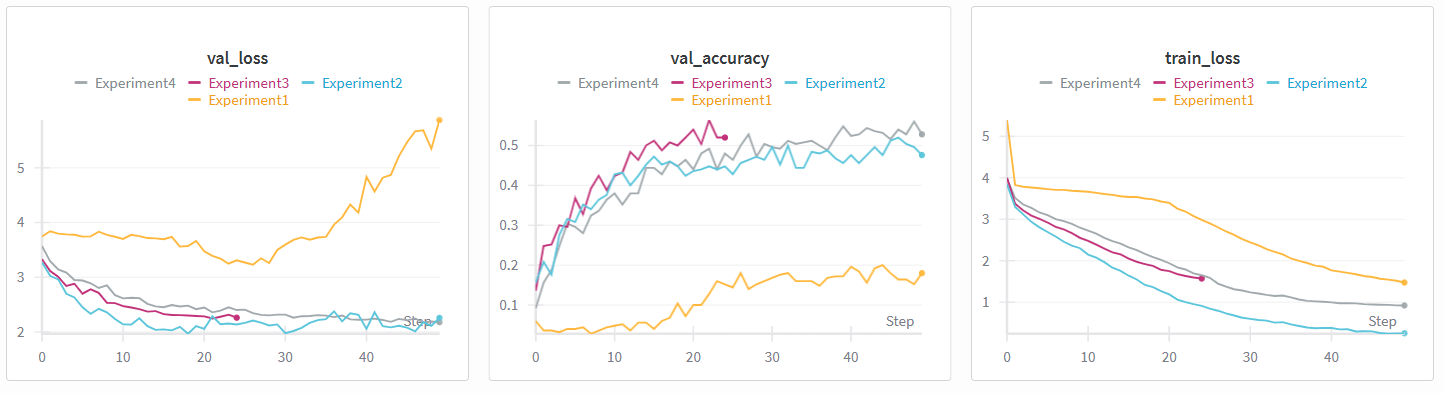

This change did not improve our model, so Experiment 3 keep being the best for now. 

At this point, we are seeing that the model is not overfitting that much. For this reason, for the next experiments we are going to do changes in order to add more data and make the model more complex.Now we are not afraid to augment data as we have seen that validation and test ditributions are generallizing well (it is not all 100%)

## New Augmentation (8000 images)

In the next cell, we created a new functions (in order not go to the preprocessing script) that augments a dataset (only training) till the indicated number of samples. To do so, it calculates the number of augmentations for class in order to add the same number for all classes. The augmentations are performed on random images for the class and using random augmenations between those explained in the preprocessing (not other ones).

In [35]:
def augment_dataset(dataset_dir,csv_path,target_total_images,output_csv_path,dry_run=True):

    def random_transform(img):
        tf = random.choice([
            lambda x: F.hflip(x),
            lambda x: F.rotate(x, 15),
            lambda x: F.adjust_brightness(x, 1 + random.uniform(-0.2, 0.2)),
            lambda x: F.adjust_contrast(x, 1 + random.uniform(-0.2, 0.2)),
            lambda x: F.adjust_saturation(x, 1 + random.uniform(-0.2, 0.2))
        ])
        return tf(img)

    df = pd.read_csv(csv_path)
    train_df = df[df['data set'] == 'train']

    class_counts = train_df['labels'].value_counts().to_dict()
    num_classes = len(class_counts)
    current_total_train = len(train_df)

    remaining_images = target_total_images - current_total_train
    images_per_class = math.ceil(remaining_images / num_classes)

    print("Current total train images:", current_total_train)
    print("Augmentations needed per class:", images_per_class)

    new_rows = []

    for class_name, count in class_counts.items():
        class_images = train_df[train_df['labels'] == class_name]['filepaths'].tolist()
        class_dir = os.path.join(dataset_dir, "train", class_name)

        for i in range(images_per_class):
            img_rel_path = random.choice(class_images)
            img_path = os.path.join(dataset_dir, img_rel_path)
            img = Image.open(img_path).convert("RGB")

            aug_img = random_transform(img)

            base_name = os.path.splitext(os.path.basename(img_path))[0]
            aug_name = f"{base_name}_aug2_{i}.jpg"
            aug_rel_path = os.path.join("train", class_name, aug_name)
            aug_save_path = os.path.join(dataset_dir, aug_rel_path)

            if not dry_run:
                aug_img.save(aug_save_path)
    
            original_row = train_df[train_df['filepaths'] == img_rel_path].iloc[0]
            new_row = {
                'class id': original_row['class id'],
                'filepaths': aug_rel_path,
                'labels': original_row['labels'],
                'data set': original_row['data set']
            }
            new_rows.append(new_row)

    if not dry_run:
        df_augmented = pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)
        df_augmented.to_csv(output_csv_path, index=False)

    print(f"Augmentation complete. {len(new_rows)} new rows {'would be added' if dry_run else 'added'}.")

In [ ]:
# src_dir = "/kaggle/input/sports-classification-data/data/data"
# dst_dir = "/kaggle/working/data"

# shutil.copytree(src_dir, dst_dir)

# print(f"Data copied to: {dst_dir}")

In [ ]:
dataset_dir = "/kaggle/working/data"
csv_path = "/kaggle/input/sports-classification-data/sports5.csv"
target_total_images = 8000
output_csv_path = "sports5_augmented8000.csv"

augment_dataset(dataset_dir, csv_path, target_total_images=8000, output_csv_path=output_csv_path, dry_run=False)

## Experiment 5

Now that we already have augmented the data to have aproximately 8000 training samples (so 2000 were added), for experiment 5 we will perform the same experiment as before but with this new data, to see how the model scales on our data.

In [36]:
exp5_config = replace(exp3_config, run_name="Experiment5")

In [ ]:
# model_exp5 = CNN(exp5_config)
# Experiment5_model = train_model(model_exp5,exp5_config,train_loader,valid_loader,device="cuda")

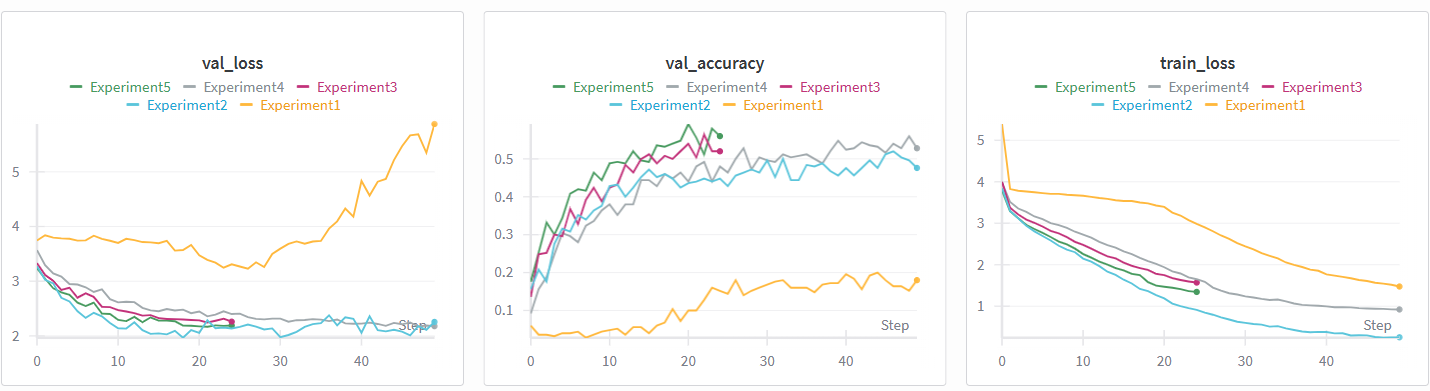



Looking at the green line, behaviour was the same but results were better, as it was expected. We achieved a greater maximum accuracy (around 0.6) and both losses were reduced.

## Experiment 6

For this experiment, we will keep making our data bigger, as we have seen that it gives better results. Now we will add 2000 more samples, to see how results improve, if they improve.

In [ ]:
dataset_dir = "/kaggle/working/data"
csv_path = "/kaggle/working/sports5_augmented8000.csv"
target_total_images = 10000
output_csv_path = "sports5_augmented10000.csv"

augment_dataset(dataset_dir, csv_path, target_total_images=10000, output_csv_path=output_csv_path, dry_run=False)

In [37]:
exp6_config = replace(exp5_config, epochs = 50, run_name="Experiment6")

In [ ]:
# model_exp6 = CNN(exp6_config)
# Experiment6_model = train_model(model_exp6,exp6_config,train_loader,valid_loader,device="cuda")

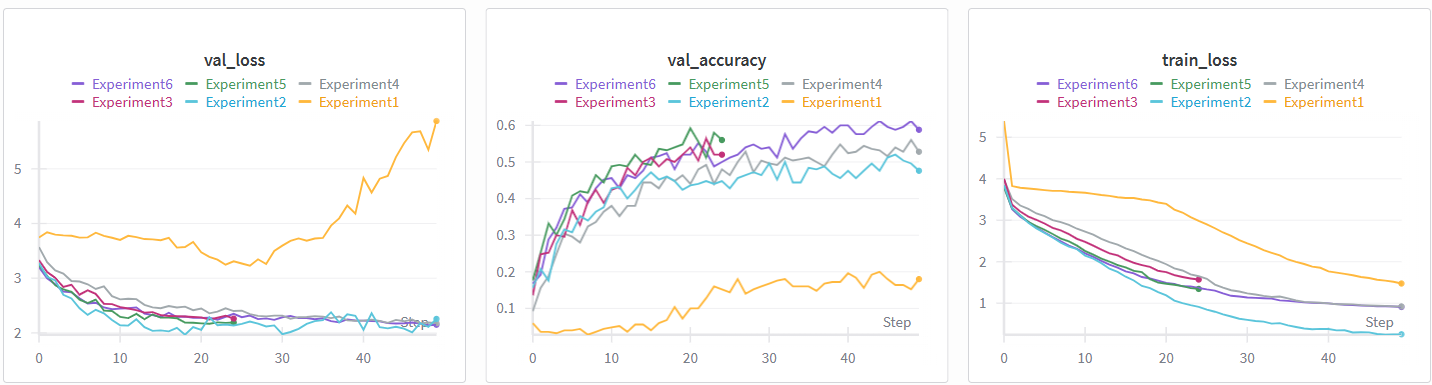

For this experiment we used 50 epochs, and we see that it was benefitial. Accuracy results were improved a little bit, reaching our maximum accuracy at the moment: 0.6120 (61,20%). 

However, this time results did not improve that much, se we will stop making our data bigge. Instead, we are going to make our Network bigger, as we see that there is rome for improvement in the loss and we are still not overfitting, so we can try.

## Experiment 7

This time we have made our network bigger. The changes of the configuration have been:

- Added two more convolutional blocks (of size 256 and 512 respectively) in order to extract more deeper features for the images.
- Added a bit of dropout in some of the deeper blocks of the CNN
- Increased dropout on the fully connected part
- Used only 1 fully connected layer and added Global Average pooling before it in order not to overload the mlp part and to generalize more (and avoid overfitting).

In [38]:
exp7_config = replace(
    exp6_config,
    conv_layers=(
        {
            "out_channels": 64,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.0,
            "pool": {"type": "max", "kernel": 2, "stride": 2},
        },
        {
            "out_channels": 128,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.05,
            "pool": {"type": "max", "kernel": 2, "stride": 2},
        },
        {
            "out_channels": 256,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.1,
            "pool": {"type": "max", "kernel": 2, "stride": 2},
        },
        {
            "out_channels": 256,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.1,
            "pool": None,
        },
        {
            "out_channels": 512,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.1,
            "pool": None,
        },
    ),
    hidden_layers=(512,),
    fc_dropout=0.4,   
    skip_connections=False,
    batch_size=64,
    epochs=80,             
    weight_decay=1e-4,
    run_name="Experiment7",
)

In [ ]:
# model_exp7 = CNN(exp7_config)
# Experiment7_model = train_model(model_exp7,exp7_config,train_loader,valid_loader,device="cuda")

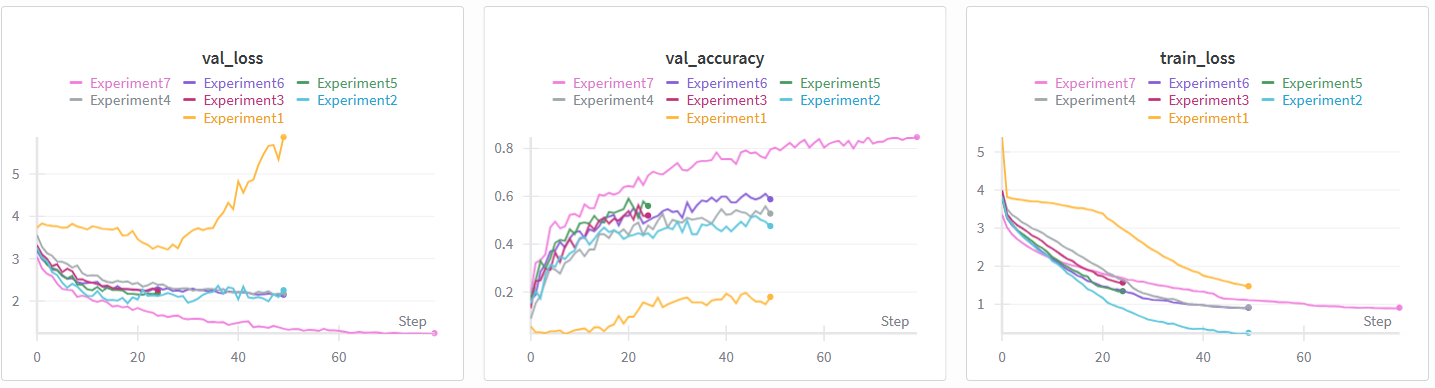

As we can see, Experiment 7 has improved a lot the results, overperforming all the models used before. Maximum accuracy reached was 84,8% before trigerring the early stopping. This is great result taking into account the previous models. Looking at the loss, we can see how validation loss decreases way more than the other models without overfitting, as training loss does not decrease much more. In fact, the regularization works that well that it is the model where training and validation loss are the closest, which means we have still range for improvement.

## Experiment 8

For the next experiment, we only wan to see if using skip connections helps our model. We try this because we are making our model deeper, so we it is a great idea to reuse information from other layers in order not to loose performance.

In [39]:
exp8_config = replace(exp7_config, skip_connections = True, epochs = 100, run_name="Experiment8")

In [ ]:
# model_exp8 = CNN(exp8_config)
# Experiment8_model = train_model(model_exp8,exp8_config,train_loader,valid_loader,device="cuda")

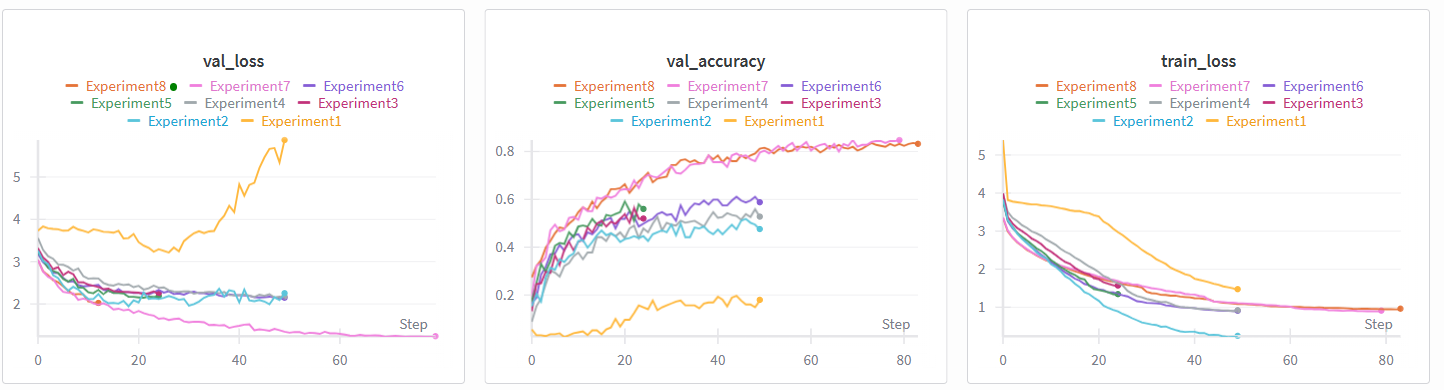

Adding skip connections did not help much our model. We found a our best accuracy in Experiment 7, but performance in Experiment 8 was pretty identical.

## Experiment 9

We want to keep making the model more complex as signs of overfitting are the same as before. For this reason, we have added a new convolutional block at the end. This convolutional block output a block of size 1024, which is pretty big. Training will take longer, but we expect to give better results.

In [40]:
exp9_config = replace(
    exp7_config,
    conv_layers=(
        {
            "out_channels": 64,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.0,
            "pool": {"type": "max", "kernel": 2, "stride": 2},
        },
        {
            "out_channels": 128,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.05,
            "pool": {"type": "max", "kernel": 2, "stride": 2},
        },
        {
            "out_channels": 256,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.10,
            "pool": {"type": "max", "kernel": 2, "stride": 2},
        },
        {
            "out_channels": 256,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.10,
            "pool": None,
        },
        {
            "out_channels": 512,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.10,
            "pool": {"type": "max", "kernel": 2, "stride": 2},
        },
        {
            "out_channels": 1024,
            "kernel_size": 3,
            "stride": 1,
            "padding": 1,
            "activation": "relu",
            "batch_norm": True,
            "dropout": 0.15,
            "pool": None,
        },
    ),
    hidden_layers=(512,),
    fc_dropout=0.4,
    skip_connections=False,
    batch_size=64,
    epochs=100,
    weight_decay=1e-4,
    run_name="Experiment9",
)


In [7]:
# model_exp9 = CNN(exp9_config)
# Experiment9_model = train_model(model_exp9,exp9_config,train_loader,valid_loader,device="cuda")

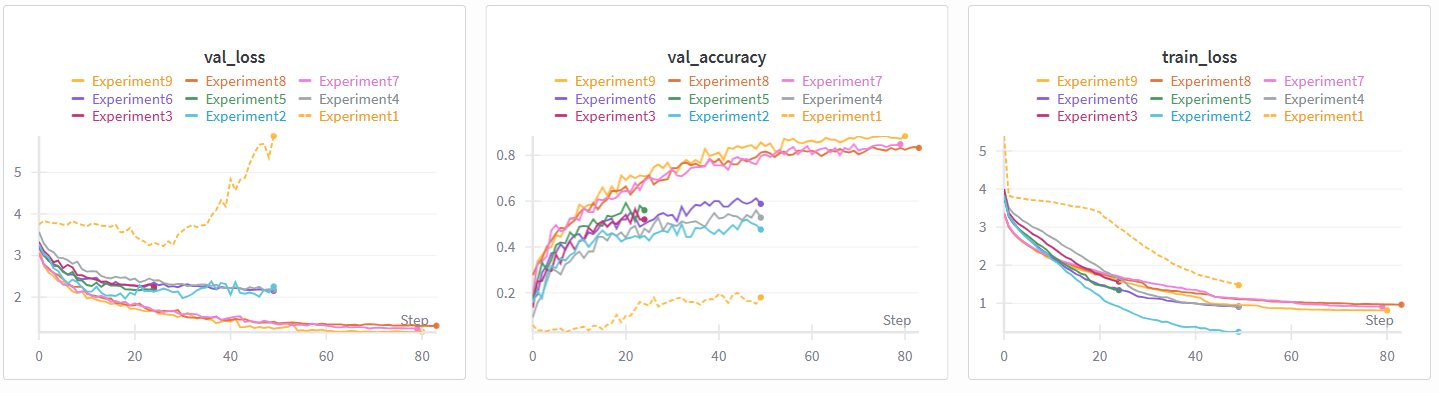

We can see how this last change improved the results. Its best result was 88,4% accuracy, which is the best we have found yet, proving again that making our network deeper is beneificial and gives better results. However, tha change this time was not that bigger as experiment 7, which means our network is learning all it is capable to learn, and we may add more data in order to get better results.

## Best Model and Final Results

Our last experiment (experiment 9) is the one who gave the best results. This network arquitecture is the following:

- conv blocks (all 2x2 max-pooling except 4th and 6th block)
  - 64 output layers
  - 128 output layers (0.05 dropout) 
  - 256 output layers (0.1 drouput)
  - 256 output layers (0.1 drouput)
  - 512 output layers (0.1 drouput)
  - 1024 output layers (0.1 drouput)
- mlp (1 layer 512 neurons with 0.4 droput)
- No skip connections
- Batch_size: 64
- early stopping

This model gave a 88,4% of validation accuracy. Let's see if it is able to generalize well to test data.

In [75]:
def evaluate_best_model(model_class, config, model_path, test_loader, device="Cuda", class_names=None):
    
    device = torch.device(device or config.device)

    model = model_class(config).to(device)
    best_state = torch.load(model_path)
    model.load_state_dict(best_state)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device).long()

            logits = model(xb)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(yb.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average="macro", zero_division=0
    )
    cm = confusion_matrix(all_labels, all_preds)

    print("\n===== FINAL TEST RESULTS =====")
    print(f"Accuracy        : {acc:.4f}")
    print(f"Macro Precision : {prec:.4f}")
    print(f"Macro Recall    : {rec:.4f}")
    print(f"Macro F1        : {f1:.4f}")

    plt.figure(figsize=(20, 20))  # bigger figure
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.xticks(rotation=90)  # rotate x labels vertically
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [68]:
def show_test_predictions(model_class,config,model_path, test_loader,class_names=None,device="Cuda",num_images=8, show_correct=True):
    
    device = torch.device(device or config.device)

    model = model_class(config).to(device)
    best_state = torch.load(model_path)
    model.load_state_dict(best_state)
    model.eval()

    if class_names is None:
        class_names = [str(i) for i in range(config.output_dim)]

    images_shown = 0

    plt.figure(figsize=(14, 8))

    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device).long()

            logits = model(xb)
            preds = logits.argmax(dim=1)

            for i in range(xb.size(0)):
                if (show_correct and preds[i] == yb[i]) or (not show_correct and preds[i] != yb[i]):
                    if images_shown >= num_images:
                        plt.tight_layout()
                        plt.show()
                        return
    
                    img = xb[i].cpu().permute(1, 2, 0).numpy()
                    img = np.clip(img, 0, 1)
    
                    true_label = class_names[yb[i].item()]
                    pred_label = class_names[preds[i].item()]
    
                    plt.subplot(2, num_images // 2, images_shown + 1)
                    plt.imshow(img)
                    plt.axis("off")
                    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)

                    images_shown += 1

    plt.tight_layout()
    plt.show()

In [43]:
class_names = [
    "archery",
    "balance beam",
    "barell racing",
    "billiards",
    "bmx",
    "bobsled",
    "bungee jumping",
    "cheerleading",
    "cricket",
    "croquet",
    "curling",
    "disc golf",
    "fencing",
    "figure skating men",
    "fly fishing",
    "frisbee",
    "hammer throw",
    "hang gliding",
    "harness racing",
    "horse jumping",
    "horse racing",
    "hurdles",
    "ice climbing",
    "jai alai",
    "javelin",
    "log rolling",
    "luge",
    "motorcycle racing",
    "parallel bar",
    "pole vault",
    "rock climbing",
    "rowing",
    "sailboat racing",
    "shuffleboard",
    "sidecar racing",
    "ski jumping",
    "skydiving",
    "snowmobile racing",
    "speed skating",
    "steer wrestling",
    "sumo wrestling",
    "surfing",
    "table tennis",
    "tennis",
    "track bicycle",
    "trapeze",
    "tug of war",
    "volleyball",
    "water polo",
    "weightlifting"
]


===== FINAL TEST RESULTS =====
Accuracy        : 0.9240
Macro Precision : 0.9310
Macro Recall    : 0.9240
Macro F1        : 0.9211


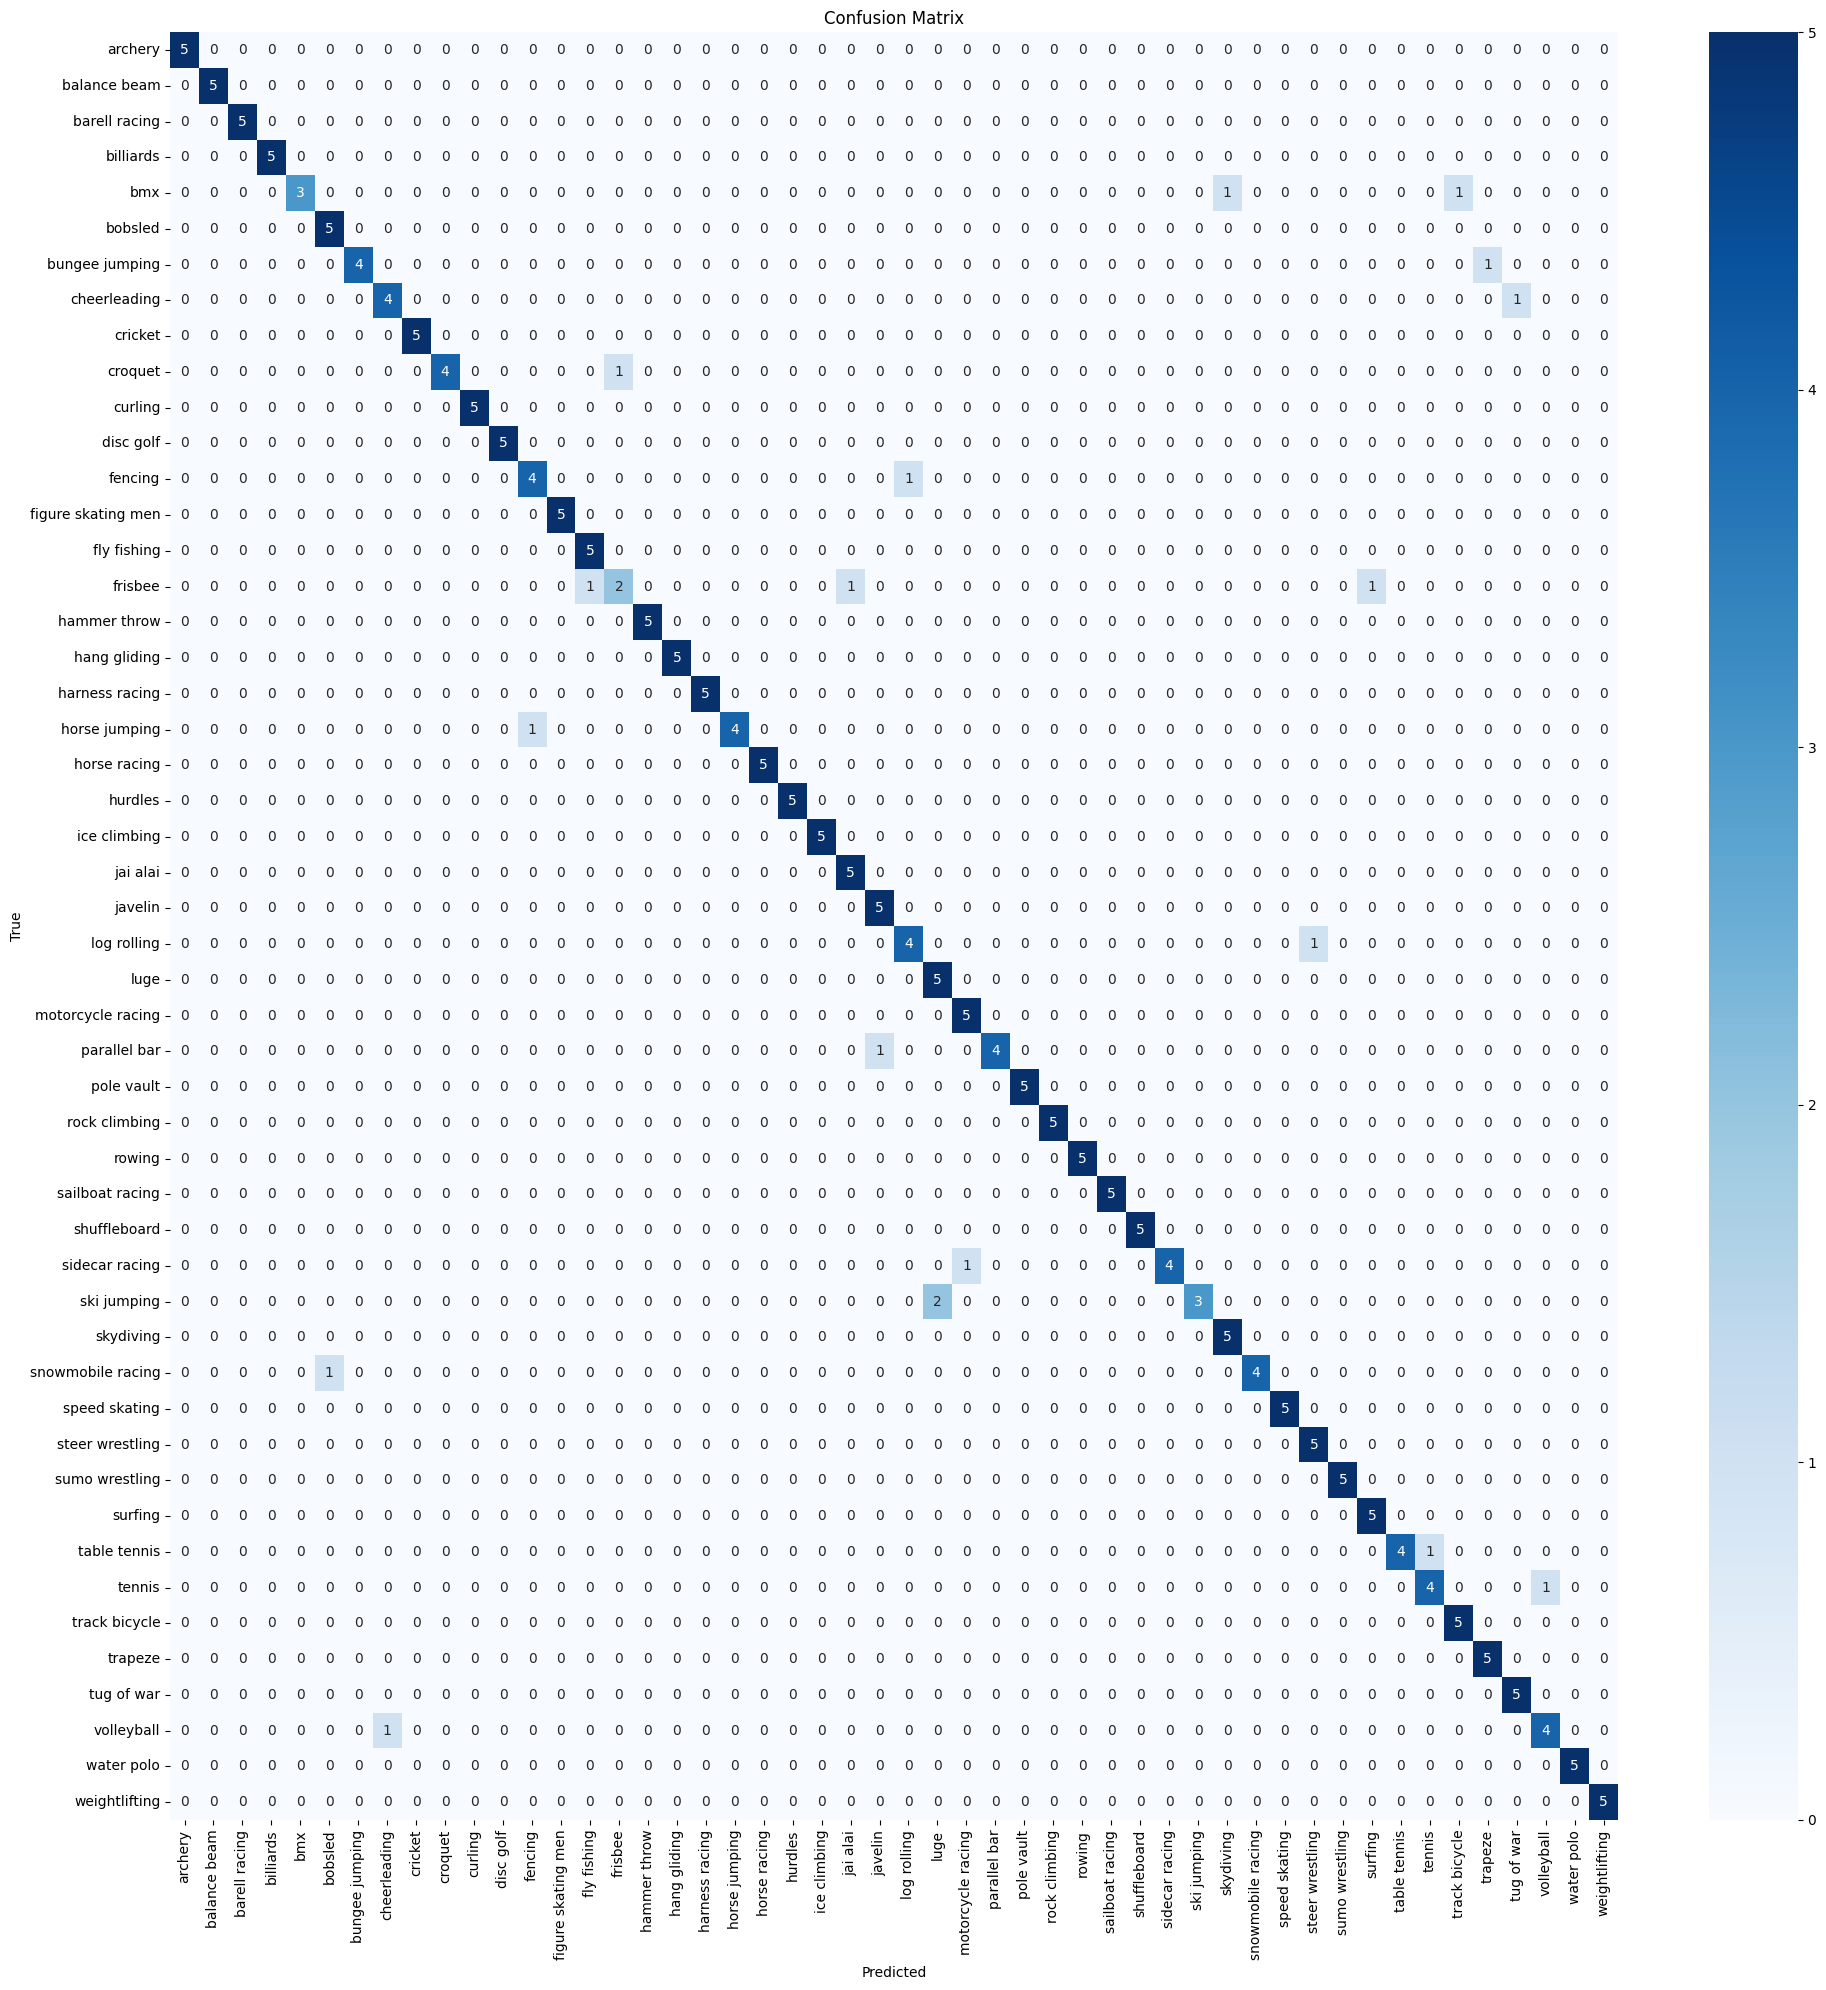

In [76]:
evaluate_best_model(CNN, exp9_config, "Experiment9.pth", test_loader, "cuda", class_names)

Here we can see how all model performed in test data. Our model obtained a 92,4% in accuracy in the test set, which is a pretty good result as it means it only gets wrong aproximately 1 out of ten images it classifies. 
It is interesting to see how we obtained a btter result in test than validation. This is strange but we think it is because we haven't a lot of test nor validation data compared of the size eith the training. For this reason, accuracy in test was better. However, we can see how it was not lower, se we see how our model has generalized pretty well to new images and has not overfit (as we have seen in the experimentation).

Looking at the confussion matrix, we can see that almost all predictions are well, except a few of them. The two classes which confused the most our model was "luge" and "ski jumping". This error is understandable as both sports have similar positions and clothes when practising them. However, it is better to look at this by looking at images of correct and wrong predictions.

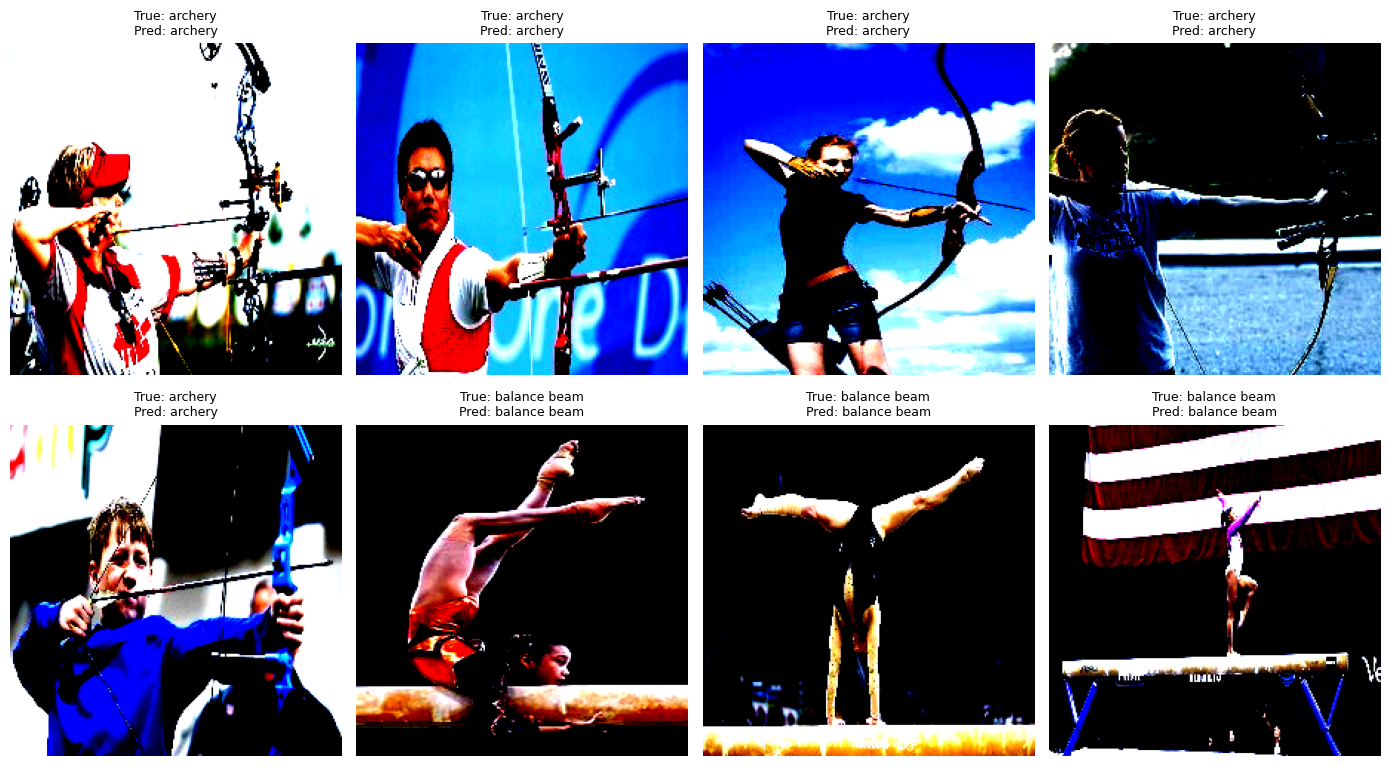

In [70]:
show_test_predictions(CNN, exp9_config, "Experiment9.pth", test_loader, class_names, "cuda", 8, show_correct=True)

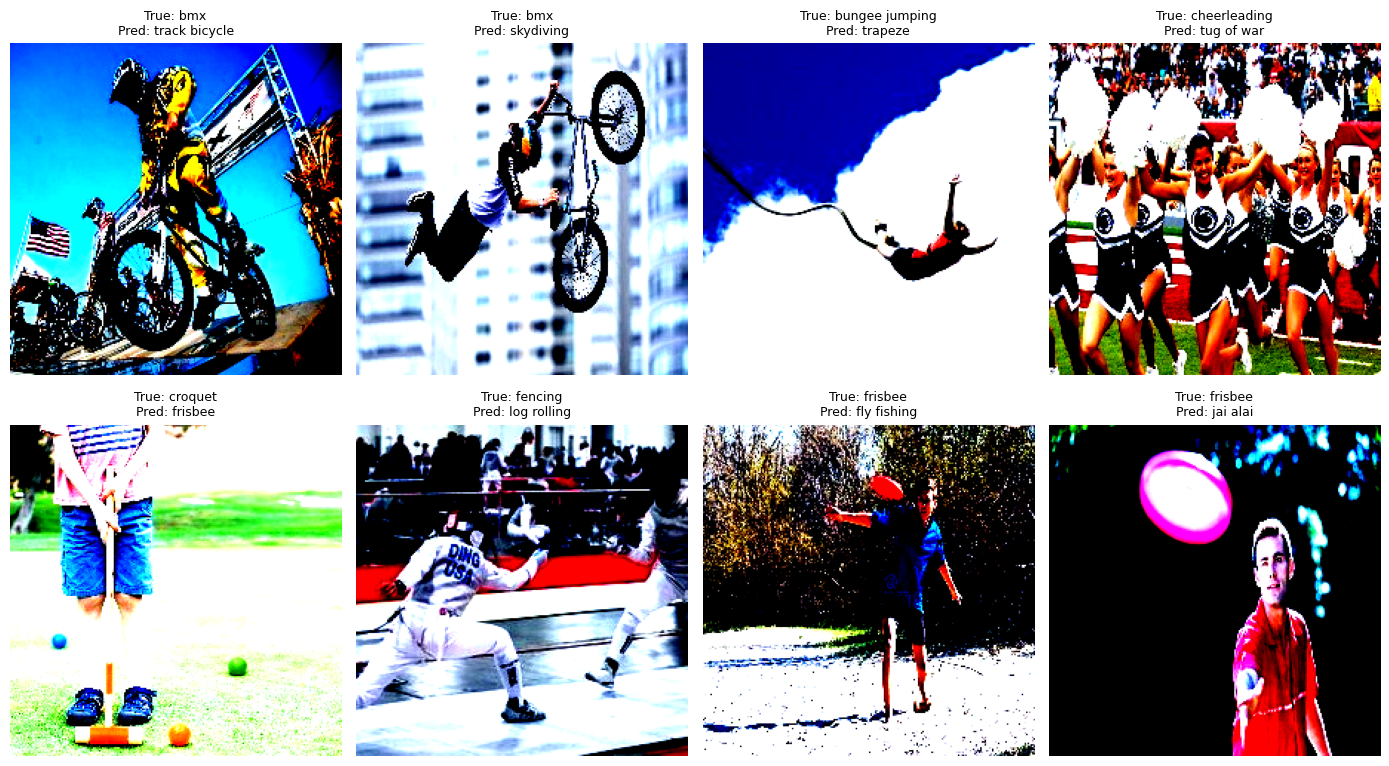

In [71]:
show_test_predictions(CNN, exp9_config, "Experiment9.pth", test_loader, class_names, "cuda", 8, show_correct=False)

This wrong predictions are the interesting part, as we can see where the model is wrong. We can see that our model performs well, as the errors are understandable,in fact, will be errores that a human (who does now all sports) would do.

## Review and Conclusions


Our result for this task is 92,4% on test accuracy. This result was given by the model and experiment commented in the previous section, which gave 88,4% of validation accuracy. We commented that this change is due to a small size of test and val data, but it is a result which represents our model because it is pretty close to validation accuracy and we have seen in our experiments that we had not much overfitting, because we treated it carefully.

Talking about our preprocessing, we think that we took pretty good decisions. Ont the one hand, we tried from the beginning to balance our dataset, so it was not biased. This was useful as we for the model as we got good results and no class was overly classified at the end. On the other hand, augmenting our data was a really good choice, as it improved a lot training as we can see in the experiments. Going up to 10000 trainign samples was a good decision because the model was able to learn more information from them and separate better the classes.

Regarding the experimentation, we have some things to comment. Firstly we have seen how useful the regularization was, as it allowed as to make our model bigger and bigger without overfitting. This was the key step. With this regularizatio, we were able to make our network deeper and it kept giving better results.

Talking about some difficulties, one of out biggest challenges was to manage and process all the data, as having that much data made our first experiments slow to execute. This problem was solved thanks to kaggle, which allowed to upload tha data fast and use its GPU, which allowed us to do our experiments really fast.